In [1]:
import mne
from pathlib import Path
data_path = r"data\first_try\mati\mati_test_real_movement_1_annotated.fif"
recording_name = Path(data_path).stem
is_real_movement = "real" in data_path.lower()
recording_type = "real_movement" if is_real_movement else "motor_imagery"

raw = mne.io.read_raw_fif(data_path, preload=True)
eeg_channels = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16"]
raw.pick(picks=eeg_channels)
raw.resample(sfreq=250)
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')
raw.notch_filter(freqs=[50.0])

mateusz_mapping = {
    'A1': 'Fp1',
    'A2': 'Fp2',
    'A3': 'F4',
    'A4': 'Fz',
    'A5': 'F3',
    'A6': 'T7',
    'A7': 'C3',
    'A8': 'Cz',
    'A9': 'C4',
    'A10': 'T8',
    'A11': 'P4',
    'A12': 'Pz',
    'A13': 'P3',
    'A14': 'O1',
    'A15': 'Oz',
    'A16': 'O2'
}

hania_mapping = {
    'A1': 'Fp1',
    'A2': 'Fp2',
    'A3': 'F4',
    'A4': 'Fz',
    'A5': 'F3',
    'A6': 'CP1', # modified
    'A7': 'C3', 
    'A8': 'Cz',
    'A9': 'C4',
    'A10': 'CP2', # modified
    'A11': 'P4',
    'A12': 'Pz',
    'A13': 'P3',
    'A14': 'FC1', # modified
    'A15': 'CPz', # modified // not sure if this is exactly correct
    'A16': 'FC2' # modified
}

raw.rename_channels(mateusz_mapping)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)

all_events, all_events_id = mne.events_from_annotations(raw)
all_events_id = {'Both feets': 1, 'Both hands': 2, 'Left hand': 3, 'Relax': 4, 'Right hand': 5}

if 'Relax' in all_events_id:
    relax_event_id = {'Relax': all_events_id['Relax']}
    del all_events_id['Relax']

task_margin = 1.0 # seconds, margin to be sure that we are focused on the task
task_end = 9.0 # seconds, to have same length for all epochs
epochs = mne.Epochs(
    raw=raw,
    events=all_events,
    event_id=all_events_id,
    baseline=None,
    tmin=task_margin,
    tmax=task_end,
    preload=True
)

task_end = 4.0
relax_epochs = mne.Epochs(
    raw=raw,
    events=all_events,
    event_id=relax_event_id,
    baseline=None,
    tmin=task_margin,
    tmax=task_end,
    preload=True
)


Opening raw data file data\first_try\mati\mati_test_real_movement_1_annotated.fif...
Isotrak not found
    Range : 0 ... 538623 =      0.000 ...   263.000 secs
Ready.
Isotrak not found
    Range : 0 ... 538623 =      0.000 ...   263.000 secs
Ready.
Reading 0 ... 538623  =      0.000 ...   263.000 secs...
Reading 0 ... 538623  =      0.000 ...   263.000 secs...


C:\Users\Mateuusz\AppData\Local\Temp\ipykernel_21024\341467907.py:8: RuntimeWarning: This filename (data\first_try\mati\mati_test_real_movement_1_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(data_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00

### Split epochs into overlapping segments
Currently I rely on moabb implementation for validation, so train/test data split is not really used, but store it as future reference. 

In [2]:
from tools import split_epochs_into_segments, merge_epochs

split_factor = 0.8
test_end = int(len(epochs) * split_factor)
test_epochs, train_epochs = epochs[:test_end], epochs[test_end:] 
print(epochs)
print(test_epochs)
print(train_epochs)
segment_length = 1.0  # seconds
step = 1.0  # seconds
splitted_test_epochs = split_epochs_into_segments(test_epochs, segment_length, step)
splitted_train_epochs = split_epochs_into_segments(train_epochs, segment_length, step)

test_relax_end = int(len(relax_epochs) * split_factor)
test_relax_epochs, train_relax_epochs = relax_epochs[:test_relax_end], relax_epochs[test_relax_end:] 
splitted_test_relax_epochs = split_epochs_into_segments(test_relax_epochs, segment_length, step)
splitted_train_relax_epochs = split_epochs_into_segments(train_relax_epochs, segment_length, step)

splitted_test_epochs = merge_epochs(splitted_test_epochs, splitted_test_relax_epochs)
splitted_train_epochs = merge_epochs(splitted_train_epochs, splitted_train_relax_epochs)

all_epochs = merge_epochs(splitted_train_epochs, splitted_test_epochs)
print(splitted_test_epochs)
all_epochs_filename = f"{recording_name}_epochs_splitted-epo.fif"
all_epochs.save(f"data/processed/{all_epochs_filename}", overwrite=True)

<Epochs | 16 events (all good), 1 – 9 s (baseline off), ~3.9 MiB, data loaded,
 'Both feets': 4
 'Both hands': 4
 'Left hand': 4
 'Right hand': 4>
<Epochs | 12 events (all good), 1 – 9 s (baseline off), ~3.0 MiB, data loaded,
 'Both feets': 3
 'Both hands': 3
 'Left hand': 3
 'Right hand': 3>
<Epochs | 4 events (all good), 1 – 9 s (baseline off), ~1.0 MiB, data loaded,
 'Both feets': 1
 'Both hands': 1
 'Left hand': 1
 'Right hand': 1>

<Epochs | 12 events (all good), 1 – 9 s (baseline off), ~3.0 MiB, data loaded,
 'Both feets': 3
 'Both hands': 3
 'Left hand': 3
 'Right hand': 3>
<Epochs | 4 events (all good), 1 – 9 s (baseline off), ~1.0 MiB, data loaded,
 'Both feets': 1
 'Both hands': 1
 'Left hand': 1
 'Right hand': 1>
{'Both feets': 1, 'Both hands': 2, 'Left hand': 3, 'Right hand': 5}
Not setting metadata
{'Both feets': 1, 'Both hands': 2, 'Left hand': 3, 'Right hand': 5}
Not setting metadata
96 matching events found
No baseline correction applied
0 projection items activated
96 

[WindowsPath('d:/STUDIA/ZPB2/3. Data gathering/data/processed/mati_test_real_movement_1_annotated_epochs_splitted-epo.fif')]

### Read saved epochs

Reading d:\STUDIA\ZPB2\3. Data gathering\data\processed\mati_test_real_movement_1_annotated_epochs_splitted-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
    Found the data of interest:
        t =       0.00 ...     996.00 ms
        0 CTF compensation matrices available
Not setting metadata
176 matching events found
No baseline correction applied
0 projection items activated
176 matching events found
No baseline correction applied
0 projection items activated
Using matplotlib as 2D backend.
Using matplotlib as 2D backend.


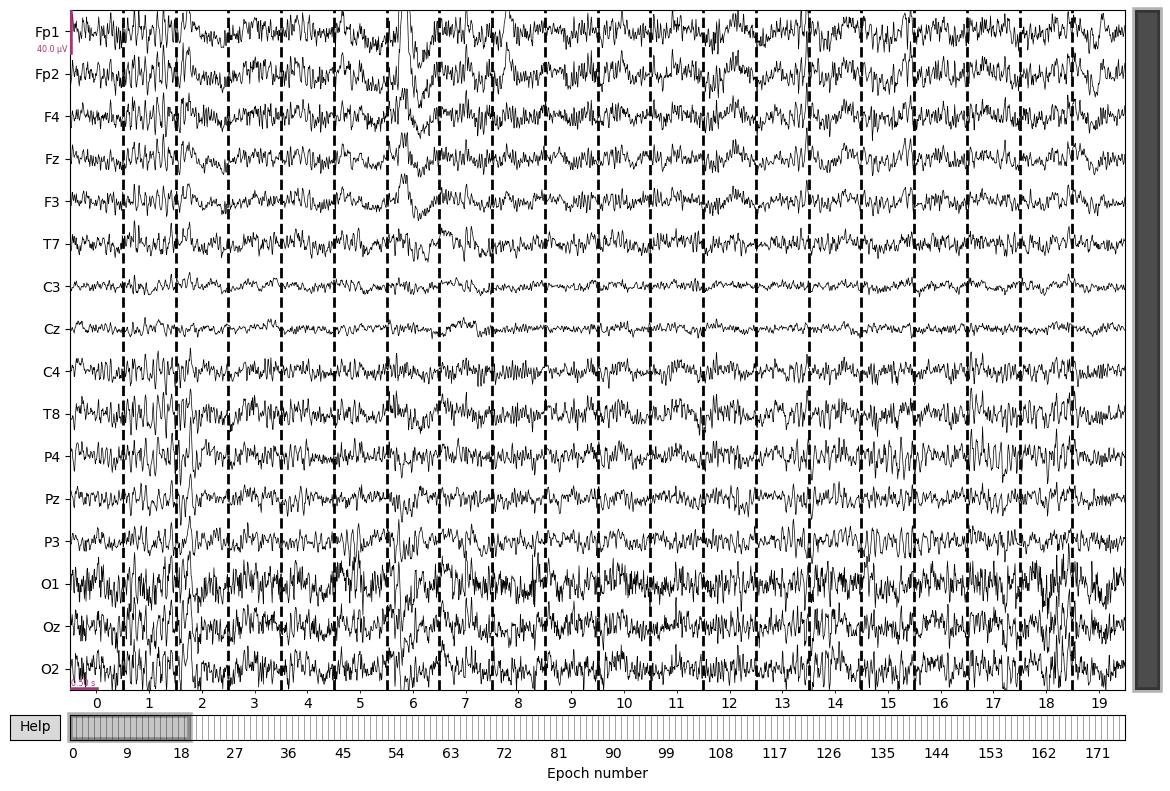

In [3]:
epochs_from_file = mne.read_epochs(f"data/processed/{recording_name}_epochs_splitted-epo.fif")
epochs_from_file.plot()
pass

In [4]:
import os
import numpy as np
import mne
from moabb.datasets.base import BaseDataset

class BrainBotDataset(BaseDataset):
    def __init__(self, data_dir, subjects, events, interval, data_names, sessions_per_subject):
        """
        Parameters
        ----------
        data_dir : str
            Path to the directory containing the data files.
        subjects : list
            List of subject identifiers.
        events : dict
            Dictionary mapping event names to event IDs.
        interval : list
            Time interval for epochs.
        data_names : dict
            Dictionary mapping subject identifiers to their corresponding data file names (can be multiple runs).
        sessions_per_subject : int
            Number of sessions per subject.
        """
        super().__init__(
            subjects=subjects,
            sessions_per_subject=sessions_per_subject,
            events=events,
            code="BrainBot",
            interval=interval,
            paradigm="imagery",
        )
        self.data_dir = data_dir
        self.data_names = data_names

    def data_path(self, subject, path=None, force_update=False, update_path=None, verbose=None):
        base = self.data_dir
        filenames = self.data_names[subject]
        epochs_files = [os.path.join(base, fname) for fname in filenames]
        return epochs_files

    def _get_single_subject_data(self, subject):
        paths = self.data_path(subject)
        sessions = {"0": {}} # sessions->runs->raw
        for i, path in enumerate(paths):
            epochs = mne.read_epochs(path, preload=True)
            data = epochs.get_data()
            n_epochs, n_ch, n_times = data.shape
            data_flat = data.transpose(1, 0, 2).reshape(n_ch, n_epochs * n_times)

            # create stim channel for moabb compatibility
            stim = np.zeros(n_epochs * n_times, dtype=int)
            for i, ev in enumerate(epochs.events):
                sample = i * n_times
                stim[sample] = int(ev[2])
            data_with_stim = np.vstack([data_flat, stim])

            sfreq = all_epochs.info['sfreq']
            ch_names = all_epochs.ch_names + ['stim']
            ch_types = ['eeg'] * n_ch + ['stim']
            info = mne.create_info(ch_names, sfreq, ch_types)
            raw = mne.io.RawArray(data_with_stim, info)
            sessions["0"][str(i)] = raw
        
        return sessions

# rename for moabb to be compatible with LeftRightImagery paradigm, which needs ["left_hand", "right_hand"] events
events_renamed = all_epochs.event_id
events_renamed = {k.replace(" ", "_").lower(): v for k, v in events_renamed.items()}

dataset = BrainBotDataset(
    data_dir="data/processed/",
    subjects=[0, 1], # 0 - hania, 1 - mati
    events=events_renamed,
    interval=[0.0, 2.0],
    data_names={
        0: [
            'hania_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'hania_imagery_movement_2_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif', # X: repeated to have 3 sessions
        ],
        1: [
            'mati_test_imagery_movement_1_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'mati_test_imagery_movement_2_squeezing_ball_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
            'mati_test_imagery_movement_3_lifting_fingers_annotated_epochs_splitted_segment=2.0-step=2.0-epo.fif',
        ],
    },
    sessions_per_subject=1,
)

D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\analysis\results.py:41: SyntaxWarning: invalid escape sequence '\w'
  "0x[\w]+>", "0x__", str_repr
The dataset class name 'BrainBotDataset' must be an abbreviation of its code 'BrainBot'. See moabb.datasets.base.is_abbrev for more information.
The dataset class name 'BrainBotDataset' must be an abbreviation of its code 'BrainBot'. See moabb.datasets.base.is_abbrev for more information.


In [5]:
from moabb.datasets import BNCI2014_001, PhysionetMI, Schirrmeister2017, Zhou2016
from moabb.paradigms import MotorImagery, LeftRightImagery
from moabb.evaluations import WithinSessionEvaluation

from sklearn.pipeline import make_pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP

import moabb

moabb.set_log_level('ERROR')
mne.set_log_level('ERROR')

datasets = [dataset]
paradigm = LeftRightImagery()

# Base classifiers and preprocessing
svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

pipelines = {}
# Keep original pipelines for reference
pipelines['CSP + SVM'] = make_pipeline(csp, svm)
pipelines['CSP + LDA'] = make_pipeline(CSP(n_components=8), LinearDiscriminantAnalysis())

from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

# TGSP (Riemannian) pipeline
pipelines['TGSP + SVM'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), SVC(kernel="linear", probability=True))

# Calibrate SVM (wrap OneVsRestClassifier). Calibration improves predict_proba quality for voting/stacking
calibrated_svm = CalibratedClassifierCV(estimator=OneVsRestClassifier(SVC(kernel='rbf', probability=True)), cv=3)
pipelines['CSP + SVM (Cal)'] = make_pipeline(CSP(n_components=4, reg=None, log=True, norm_trace=False), calibrated_svm)
pipelines['TGSP + SVM (Cal)'] = make_pipeline(Covariances("oas"), TangentSpace(metric="riemann"), CalibratedClassifierCV(estimator=SVC(kernel="linear", probability=True), cv=3))

# Build explicit ordered list of base estimators for ensembles
base_estimators = [
    ('csp_svm_cal', pipelines['CSP + SVM (Cal)']),
    ('csp_lda', pipelines['CSP + LDA']),
    ('tgsp_svm_cal', pipelines['TGSP + SVM (Cal)']),
]

# Weighted voting: favor the stronger models
voting = VotingClassifier(estimators=base_estimators, voting='soft', weights=[1, 2, 2])
pipelines['Ensemble (Weighted)'] = voting

# Stacking with a regularized meta-learner (smaller C => stronger regularization)
stacking = StackingClassifier(estimators=base_estimators, final_estimator=LogisticRegression(C=0.1, max_iter=1000), cv=5, stack_method='predict_proba')
pipelines['Stacking (All+RegLR)'] = stacking

evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=True)
results = evaluation.process(pipelines)

BrainBot-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 36 events (all good), 0 – 2 s (baseline off), ~2.2 MiB, data loaded,
 'left_hand': 20
 'right_hand': 16>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 44 events (all good), 0 – 2 s (baseline off), ~2.7 MiB, data loaded,
 'left_hand': 20
 'right_hand': 24>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 36 events (all good), 0 – 2 s (baseline off), ~2.2 MiB, data loaded,
 'left_hand': 20
 'right_hand': 16>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 44 events (all good), 0 – 2 s (baseline off), ~2.7 MiB, data loaded,
 'left_hand': 20
 'rig

No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BrainBot-WithinSession:  50%|█████     | 1/2 [00:08<00:08,  8.56s/it]D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 40 events (all good), 0 – 2 s (baseline off), ~2.5 MiB, data loaded,
 'left_hand': 20
 'right_hand': 20>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 40 events (all good), 0 – 2 s (baseline off), ~2.5 MiB, data loaded,
 'left_hand': 20
 'right_hand': 20>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 40 events (all good), 0 – 2 s (baseline off), ~2.5 MiB, data loaded,
 'left_hand': 20
 'right_hand': 20>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 40 events (all good), 0 – 2 s (baseline off), ~2.5 MiB, data loaded,
 'left_hand': 

No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.
No hdf5_path provided, models will not be saved.


BrainBot-WithinSession: 100%|██████████| 2/2 [00:16<00:00,  8.50s/it]



In [6]:
print("Results Summary:")
summary = results.groupby(['pipeline', 'dataset'])['score'].agg(['mean', 'std', 'count'])
summary['mean'] = summary['mean'].round(3)
summary['std'] = summary['std'].round(3)
print(summary.to_string())
print("=" * 50)

print("\nDetailed Results by Subject and Dataset:")
detailed = results.pivot_table(
    index=['dataset', 'subject', 'session'], 
    columns='pipeline', 
    values='score'
)
print(detailed.round(3).to_string())
print("=" * 50)

Results Summary:
                                mean    std  count
pipeline             dataset                      
CSP + LDA            BrainBot  0.717  0.108      2
CSP + SVM            BrainBot  0.719  0.062      2
CSP + SVM (Cal)      BrainBot  0.711  0.051      2
Ensemble (Weighted)  BrainBot  0.789  0.069      2
Stacking (All+RegLR) BrainBot  0.719  0.075      2
TGSP + SVM           BrainBot  0.780  0.082      2
TGSP + SVM (Cal)     BrainBot  0.767  0.033      2

Detailed Results by Subject and Dataset:
pipeline                  CSP + LDA  CSP + SVM  CSP + SVM (Cal)  Ensemble (Weighted)  Stacking (All+RegLR)  TGSP + SVM  TGSP + SVM (Cal)
dataset  subject session                                                                                                                
BrainBot 0       0            0.641      0.675            0.675                0.741                 0.666       0.722             0.744
         1       0            0.794      0.762            0.747        

## Confusion Matrices from Individual Predictions

Now let's re-run the evaluation with `save_predictions=True` to collect per-sample predictions for confusion matrices

In [7]:
# Re-run evaluation with save_predictions enabled
evaluation_with_pred = WithinSessionEvaluation(
    paradigm=paradigm, 
    datasets=datasets, 
    hdf5_path="results_with_predictions.h5",  # Use different file to preserve original results
    overwrite=True,
    save_predictions=True  # Enable per-sample prediction storage
)
results_with_pred = evaluation_with_pred.process(pipelines)
print("Evaluation complete with predictions saved!")

BrainBot-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 36 events (all good), 0 – 2 s (baseline off), ~2.2 MiB, data loaded,
 'left_hand': 20
 'right_hand': 16>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 44 events (all good), 0 – 2 s (baseline off), ~2.7 MiB, data loaded,
 'left_hand': 20
 'right_hand': 24>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 36 events (all good), 0 – 2 s (baseline off), ~2.2 MiB, data loaded,
 'left_hand': 20
 'right_hand': 16>
  warn(f"warnEpochs {epochs}")
D:\STUDIA\ZPB2\3. Data gathering\moabb\moabb\datasets\preprocessing.py:278: UserWarning: warnEpochs <Epochs | 44 events (all good), 0 – 2 s (baseline off), ~2.7 MiB, data loaded,
 'left_hand': 20
 'rig

Evaluation complete with predictions saved!



Pipeline: CSP + SVM
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


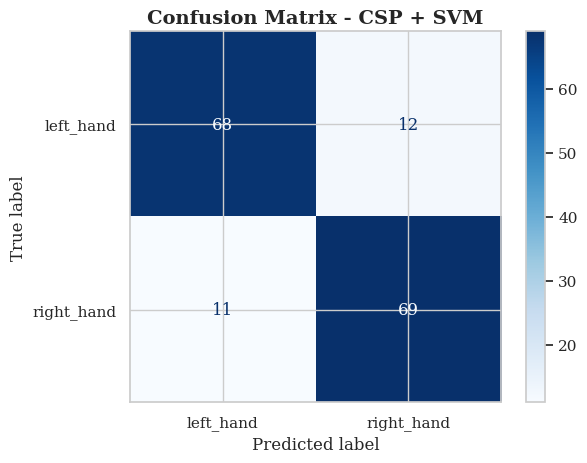


Confusion Matrix for CSP + SVM:
[[68 12]
 [11 69]]
Accuracy: 0.8562

Pipeline: CSP + LDA
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


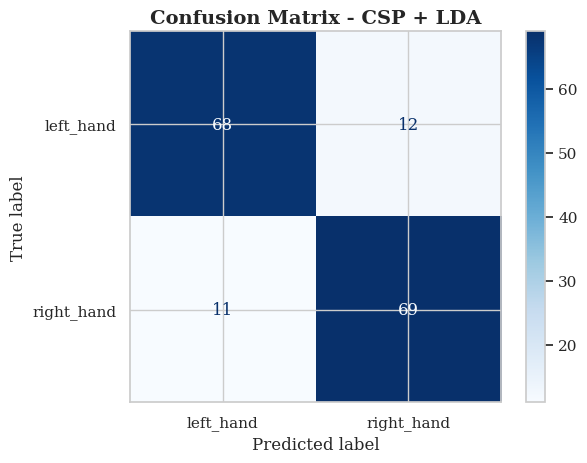


Confusion Matrix for CSP + LDA:
[[68 12]
 [11 69]]
Accuracy: 0.8562

Pipeline: TGSP + SVM
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


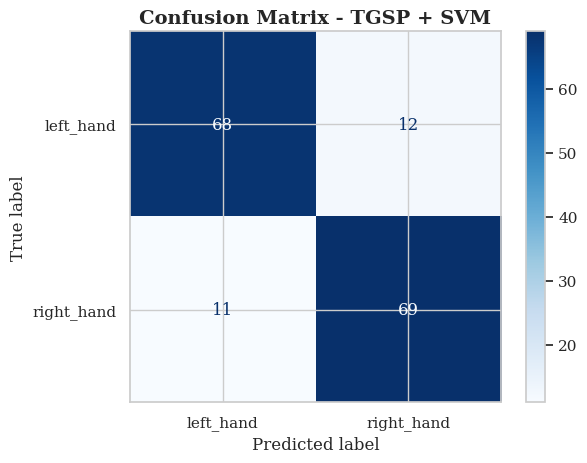


Confusion Matrix for TGSP + SVM:
[[68 12]
 [11 69]]
Accuracy: 0.8562

Pipeline: CSP + SVM (Cal)
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


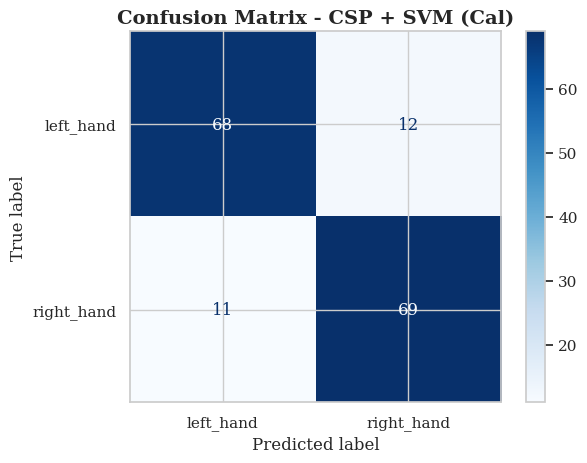


Confusion Matrix for CSP + SVM (Cal):
[[68 12]
 [11 69]]
Accuracy: 0.8562

Pipeline: TGSP + SVM (Cal)
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


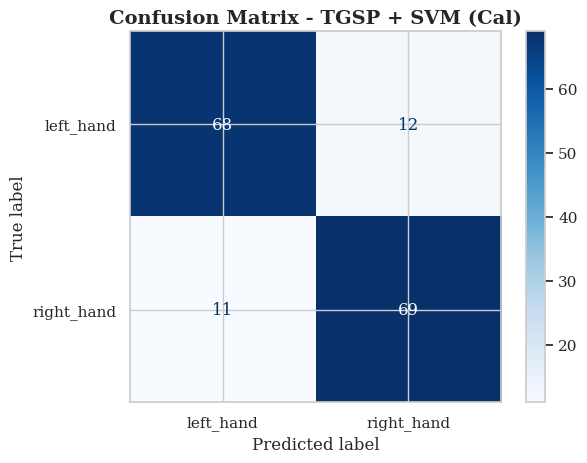


Confusion Matrix for TGSP + SVM (Cal):
[[68 12]
 [11 69]]
Accuracy: 0.8562

Pipeline: Ensemble (Weighted)
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


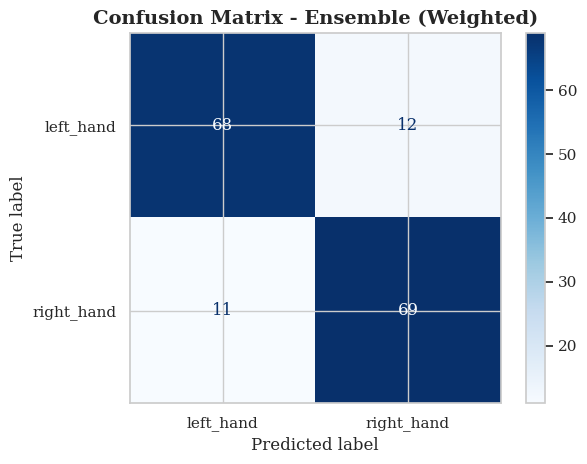


Confusion Matrix for Ensemble (Weighted):
[[68 12]
 [11 69]]
Accuracy: 0.8562

Pipeline: Stacking (All+RegLR)
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples
Subject 0, Session 0: 80 samples
Subject 1, Session 0: 80 samples


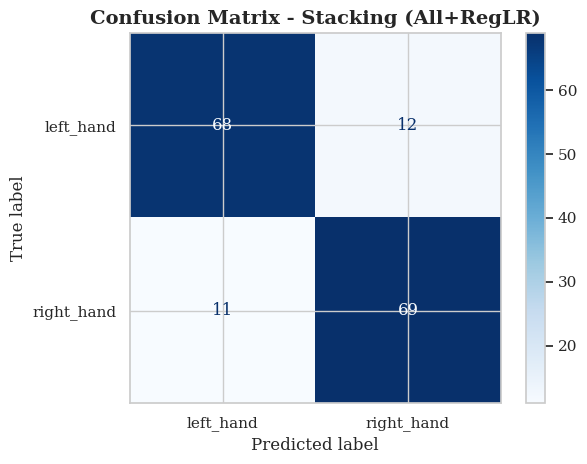


Confusion Matrix for Stacking (All+RegLR):
[[68 12]
 [11 69]]
Accuracy: 0.8562


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Use paradigm events (which filters to relevant classes), not dataset events
paradigm_class_labels = paradigm.events  # ['left_hand', 'right_hand']
paradigm_class_ids = list(range(len(paradigm_class_labels)))  # [0, 1]

# Create confusion matrices for each pipeline and subject combination
for pipeline_name in pipelines.keys():
    print(f"\n{'='*60}")
    print(f"Pipeline: {pipeline_name}")
    print(f"{'='*60}")
    
    all_y_true = []
    all_y_pred = []
    
    # Collect predictions from all subjects/sessions
    for subject in dataset.subject_list:
        for session_idx in range(dataset.n_sessions):
            session_name = str(session_idx)
            
            try:
                predictions = evaluation_with_pred.results.get_predictions(
                    dataset_code=dataset.code,
                    subject=subject,
                    session=session_name,
                    pipeline_name=pipeline_name
                )
                
                if predictions is not None:
                    all_y_true.extend(predictions['y_true'])
                    all_y_pred.extend(predictions['y_pred'])
                    print(f"Subject {subject}, Session {session_name}: {len(predictions['y_true'])} samples")
            except Exception as e:
                print(f"Could not retrieve predictions for Subject {subject}, Session {session_name}: {str(e)}")
    
    if len(all_y_true) > 0:
        # Create confusion matrix using PARADIGM events (0-indexed)
        cm = confusion_matrix(all_y_true, all_y_pred, labels=paradigm_class_ids)
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=paradigm_class_labels)
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f'Confusion Matrix - {pipeline_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\nConfusion Matrix for {pipeline_name}:")
        print(cm)
        print(f"Accuracy: {np.trace(cm) / np.sum(cm):.4f}")
    else:
        print(f"No predictions found for pipeline {pipeline_name}")

{'y_true': array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1]), 'y_pred': array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]), 'y_proba': array([9.92017925e-01, 7.98207149e-03, 9.94426072e-01, 5.57391718e-03,
       9.99558806e-01, 4.41187905e-04, 7.61987507e-01, 2.38012478e-01,
       2.12159343e-02, 9.78784084e-01, 2.53023118e-01, 7.46976852e-01,
       9.94262815e-01, 5.73717942e-03, 9.97154117e-01, 2.84586032e-03,
       9.42478359e-01, 5.75216301e-02, 9.15752590e-01, 8.42474401e-02,
       7.42576063e-01, 2.57423937e-01, 9.61226411e-03, 9.90387738e-01,
  

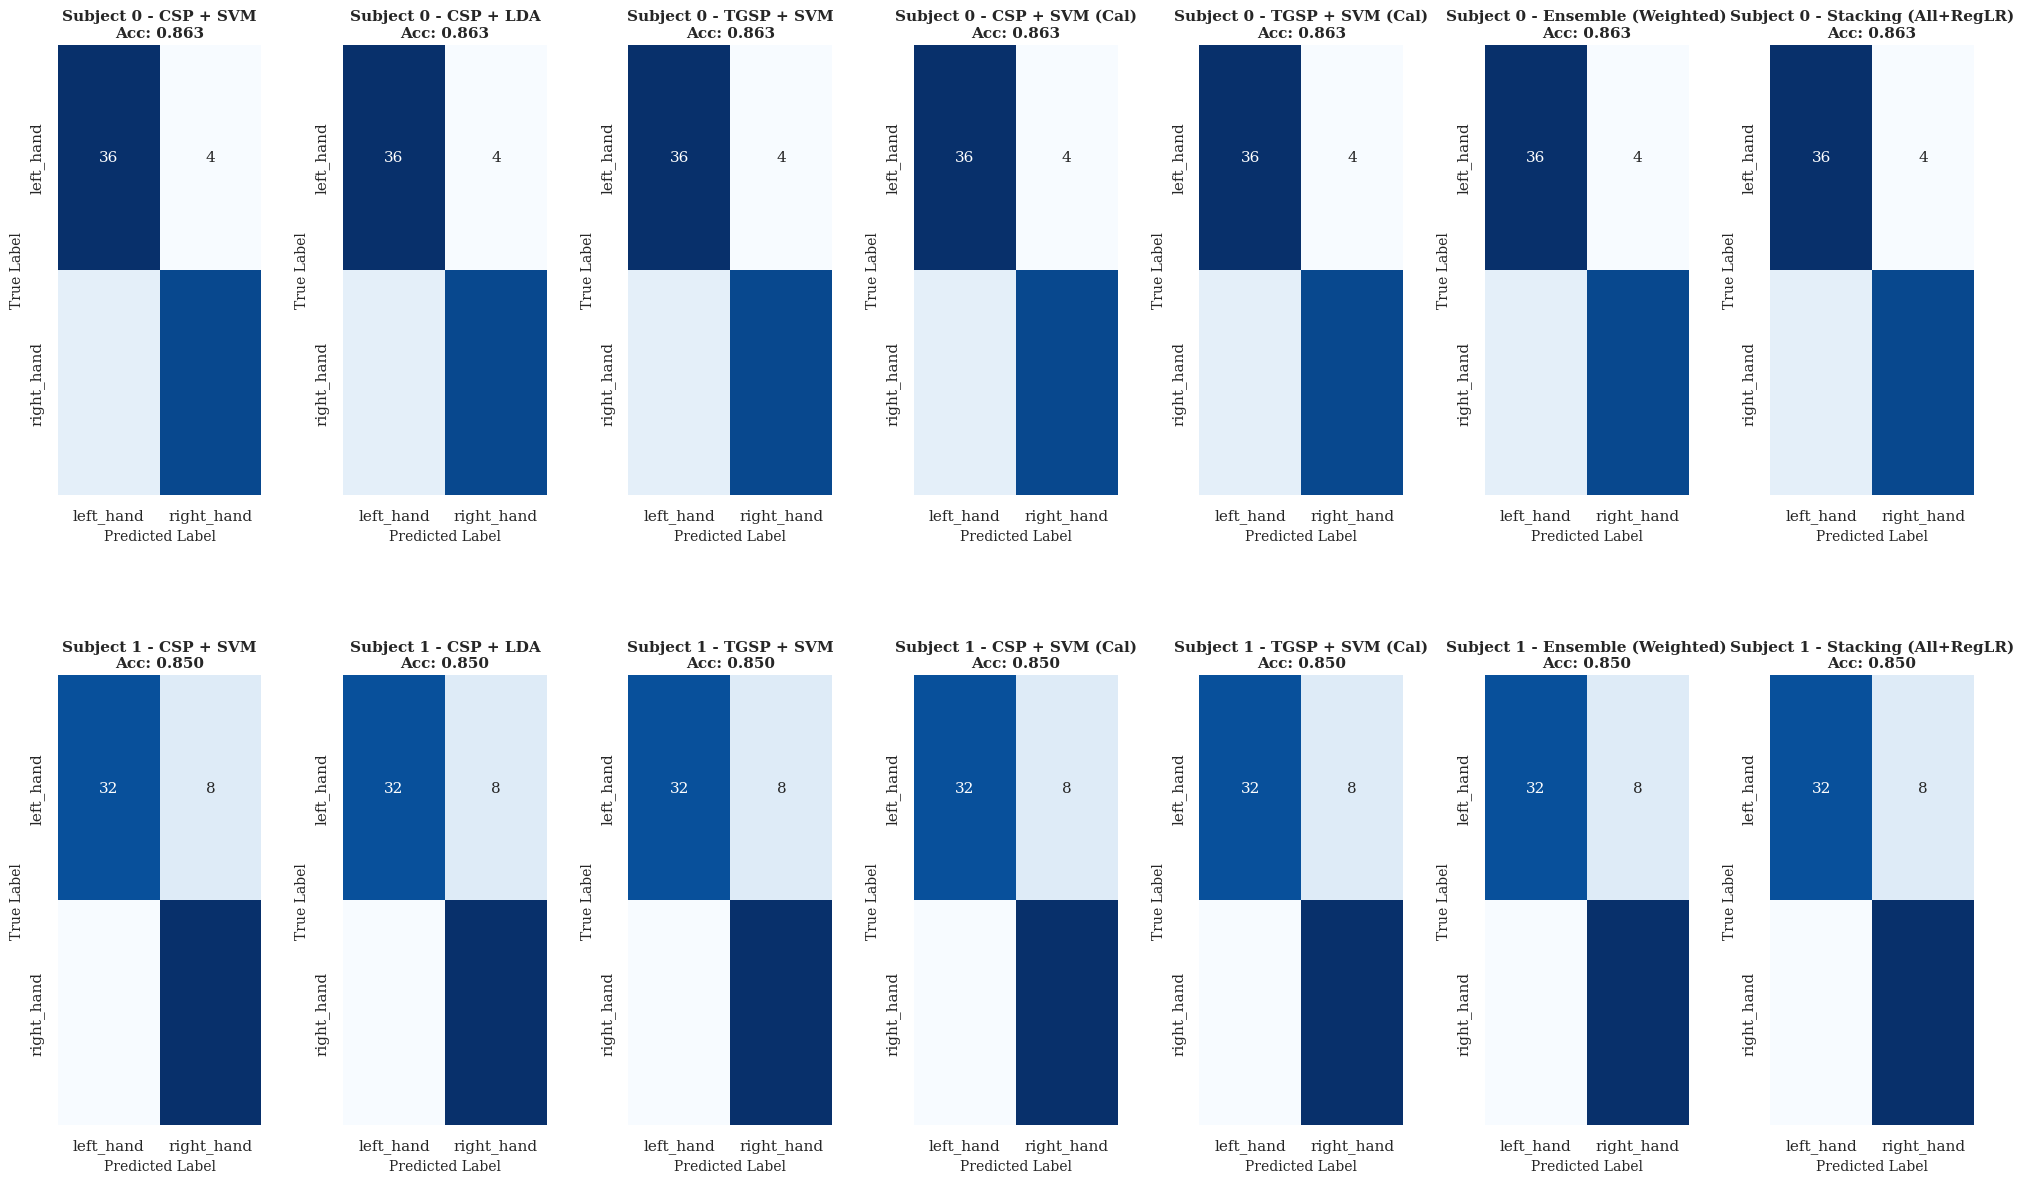

Per-subject confusion matrices created!


In [18]:
paradigm_class_labels = paradigm.events
paradigm_class_ids = list(range(len(paradigm_class_labels)))

fig, axes = plt.subplots(len(dataset.subject_list), len(pipelines), 
                         figsize=(20, 6*len(dataset.subject_list)))

if len(dataset.subject_list) == 1:
    axes = axes.reshape(1, -1)
elif len(pipelines) == 1:
    axes = axes.reshape(-1, 1)

for subject_idx, subject in enumerate(dataset.subject_list):
    for pipeline_idx, pipeline_name in enumerate(pipelines.keys()):
        try:
            predictions = evaluation_with_pred.results.get_predictions(
                dataset_code=dataset.code,
                subject=subject,
                session="0",
                pipeline_name=pipeline_name
            )
            print(predictions)
            
            if predictions is not None:
                cm = confusion_matrix(predictions['y_true'], predictions['y_pred'], 
                                    labels=paradigm_class_ids)
                ax = axes[subject_idx, pipeline_idx]
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                           xticklabels=paradigm_class_labels, yticklabels=paradigm_class_labels,
                           ax=ax, cbar=False, annot_kws={'size': 11})

                accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) > 0 else 0
                ax.set_title(f'Subject {subject} - {pipeline_name}\nAcc: {accuracy:.3f}', 
                            fontsize=11, fontweight='bold')
                ax.set_ylabel('True Label', fontsize=10)
                ax.set_xlabel('Predicted Label', fontsize=10)
        except Exception as e:
            ax = axes[subject_idx, pipeline_idx]
            ax.text(0.5, 0.5, f'No data\nfor {pipeline_name}', 
                   ha='center', va='center', fontsize=10)
            ax.set_xticks([])
            ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

print("Per-subject confusion matrices created!")

## Detailed Analysis with Per-Fold Metrics

Extract fold-specific information to analyze model consistency across folds

In [10]:
# Analyze per-fold consistency
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score

print("\n" + "="*80)
print("PER-FOLD ANALYSIS - Model Consistency Across Cross-Validation Folds")
print("="*80)

for pipeline_name in pipelines.keys():
    print(f"\n{pipeline_name}")
    print("-" * 80)
    
    for subject in dataset.subject_list:
        try:
            predictions = evaluation_with_pred.results.get_predictions(
                dataset_code=dataset.code,
                subject=subject,
                session="0",
                pipeline_name=pipeline_name
            )
            
            if predictions is not None:
                y_true = predictions['y_true']
                y_pred = predictions['y_pred']
                fold_ids = predictions.get('fold_id', np.zeros(len(y_true), dtype=int))
                
                print(f"\n  Subject {subject}:")
                
                # Overall metrics
                overall_acc = accuracy_score(y_true, y_pred)
                overall_balanced_acc = balanced_accuracy_score(y_true, y_pred)
                overall_f1 = f1_score(y_true, y_pred, average='weighted')
                
                print(f"    Overall - Acc: {overall_acc:.4f}, Balanced Acc: {overall_balanced_acc:.4f}, F1: {overall_f1:.4f}")
                
                # Per-fold metrics
                if isinstance(fold_ids, np.ndarray) and len(np.unique(fold_ids)) > 1:
                    print(f"    Per-fold metrics:")
                    for fold in sorted(np.unique(fold_ids)):
                        if fold >= 0:  # Skip invalid fold markers
                            mask = fold_ids == fold
                            fold_acc = accuracy_score(y_true[mask], y_pred[mask])
                            fold_samples = np.sum(mask)
                            print(f"      Fold {int(fold)}: Acc: {fold_acc:.4f} (n={fold_samples})")
        except Exception as e:
            print(f"  Could not analyze Subject {subject}: {str(e)}")


PER-FOLD ANALYSIS - Model Consistency Across Cross-Validation Folds

CSP + SVM
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8625, Balanced Acc: 0.8625, F1: 0.8623

  Subject 1:
    Overall - Acc: 0.8500, Balanced Acc: 0.8500, F1: 0.8496

CSP + LDA
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8625, Balanced Acc: 0.8625, F1: 0.8623

  Subject 1:
    Overall - Acc: 0.8500, Balanced Acc: 0.8500, F1: 0.8496

TGSP + SVM
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8625, Balanced Acc: 0.8625, F1: 0.8623

  Subject 1:
    Overall - Acc: 0.8500, Balanced Acc: 0.8500, F1: 0.8496

CSP + SVM (Cal)
--------------------------------------------------------------------------------

  Subject 0:
    Overall - Acc: 0.8625, Balanced Acc: 0.8625, F1: 0.8623

  Subject 1:
    Overall - Acc: 0.850